### CAUSAL DISCOVERY - PETER CLARK

 * This notebook is used for testing the Peter-Clark Algorithm for Causal Discovery using Py-Why
 * The Peter-Clark Algorithm is a Constraint-Based Algorithm method for inferring causal relationships from observational data.
 * It is commonly used in the field of causal inference and can help identify cause-effect relationships between variables in a dataset.
 * For more information on the Peter-Clark Algorithm and how to get started with causal inference, please refer to the documentation at: [https://causal-learn.readthedocs.io/en/latest/getting_started.html](https://causal-learn.readthedocs.io/en/latest/getting_started.html)


In [13]:
!pip install -r requirement.txt

In [14]:
import os, time
import sys
sys.path.append("")
import unittest
import hashlib
import numpy as np
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import chisq, fisherz, gsq, kci, mv_fisherz, d_separation
from causallearn.graph.SHD import SHD
from causallearn.utils.DAG2CPDAG import dag2cpdag
from causallearn.utils.TXT2GeneralGraph import txt2generalgraph
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import pickle
# from .utils_simulate_data import simulate_discrete_data, simulate_linear_continuous_data
from causallearn.graph.GraphClass import CausalGraph
from causallearn.graph.GraphNode import GraphNode
from causallearn.utils.cit import fisherz, mv_fisherz
from causallearn.utils.PCUtils import SkeletonDiscovery
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.utils.PCUtils.BackgroundKnowledgeOrientUtils import \
    orient_by_background_knowledge

# or save the graph
from causallearn.utils.GraphUtils import GraphUtils


import gc
gc.collect()

8381

### LOADING DATASET

In [22]:
# Load data
def load_data_save_to_txt():
    """
    Load data from either a pickle file or a CSV file and save it to a text file.

    Returns:
        pandas.DataFrame: The loaded data.
    """
    pickle_file_path = "./data/output.p"
    csv_file_path = "./data/output.csv"
    txt_file_path = './data/output.txt'

    if os.path.exists(pickle_file_path):
        df = pd.read_pickle(pickle_file_path)
    else:
        df = pd.read_csv(csv_file_path)
        df.to_pickle(pickle_file_path, protocol=pickle.HIGHEST_PROTOCOL)

    df.to_csv(txt_file_path, sep='\t', index=False)

    return df


In [23]:
# View the first few rows of the data
try:
    df = load_data_save_to_txt()
    df.head()
except Exception as e:
    print(f"Csv or Pickle file not found")


In [24]:
## Load data for Causal Discovery from a txt file
def load_txt_dag_data(data_path, num_rows):
    """
    Load data from a text file.

    Args:
        data_path (str): Path to the data file.
        num_rows (int): Number of rows to load from the data file. If None, all rows will be loaded.

    Returns:
        numpy.ndarray: The loaded data as a numpy array.
    """
    full_data = np.loadtxt(data_path, skiprows=1)

    # Randomly select num_rows rows
    if num_rows is not None:
        indices = np.random.choice(full_data.shape[0], num_rows, replace=False)
        data = full_data[indices, :]
    else:
        data = full_data

    return data

## Load Ground Truth Directed Acyclic Graph (DAG)
def load_truth_dag(truth_graph_path):
    """
    Load the ground truth directed acyclic graph (DAG) from a text file.

    Args:
        truth_graph_path (str): Path to the truth graph file.

    Returns:
        Graph: The loaded truth DAG.
    """

    truth_dag = txt2generalgraph(truth_graph_path)
    return truth_dag

# Usage example:
# Load data
data_path = "./data/output.txt"   # "output.txt"
truth_graph_path = "./data/graph.10.txt"
num_rows = 1000 #select number of rows to load or None

data = load_txt_dag_data(data_path, num_rows)

In [25]:
# txt_file_path = 'your_file.txt'

# Read the first line of the text file
with open(data_path, 'r') as file:
    first_line = file.readline().strip()  # Read the first line and remove leading/trailing whitespace

# Assuming the header is separated by commas, split the line based on the delimiter
header = first_line.split('\t')

# Print or use the header
print(header)

['bandwidth', 'responsetime', 'visitors', 'sensor', 'location_encoded']


### RUNNING ALGORITHM

  0%|          | 0/3 [00:00<?, ?it/s]

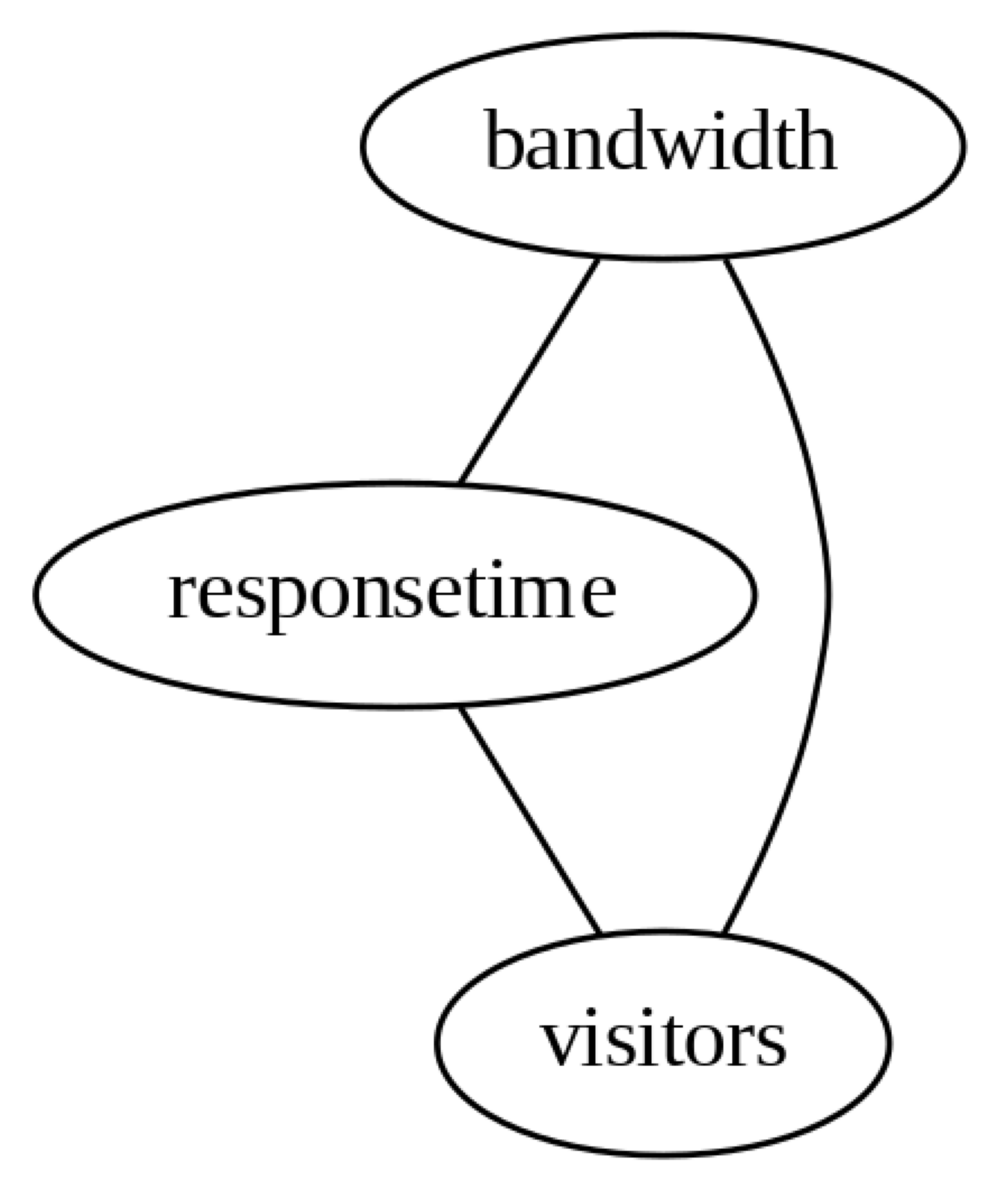

Time taken for PC algorithm: 4.545 seconds


In [19]:
def run_causal_discovery(data):
    """
    Runs the modified PC algorithm for causal discovery on the given data.

    Parameters:
    - data: The input data for causal discovery.
    - alpha: The significance level for conditional independence tests.
    - indep_test: The independence test to use.
        # “fisherz”, “chisq”, “gsq”, “kci”, “mv_fisherz”
    - stable: Whether to use the stable PC algorithm.
    - uc_rule: The unshielded colliders rule to use.
    - uc_priority: The priority of unshielded colliders.
    - mvpc: Whether to use the modified v-structure phase condition.
    - correction_name: The name of the correction to use.
    - background_knowledge: Background knowledge to incorporate in the causal discovery.
    - verbose: Whether to print verbose output.
    - show_progress: Whether to show progress during the algorithm execution.

    Returns:
    - cg: The causal graph object representing the discovered causal relationships.

    Example usage:
    cg = run_causal_discovery(data, 0.05, kci, stable=True, uc_rule=1, uc_priority=1, mvpc=True, correction_name='fdr_bh', background_knowledge=None, verbose=True, show_progress=True)
    """
    # cg = pc(data, alpha, indep_test, stable, uc_rule, uc_priority, mvpc, correction_name, background_knowledge, verbose, show_progress)

    # default parameters
    start_time = time.time()

    citest_cache_file = "./cache/citest_cache_kci.json"    # .json file
    cg = pc(data, 0.1, kci, cache_path=citest_cache_file, uc_priority=-1)             # after the long run

    # cg = pc(data, 0.05, kci, cache_path=citest_cache_file)


    # visualization using pydot
    cg.draw_pydot_graph(labels=header)

    # save the graph
    pyd = GraphUtils.to_pydot(cg.G, labels=header)
    pyd.write_png('PC_graph_test.png')

    # # visualization using networkx
    # cg.to_nx_graph()
    # cg.draw_nx_graph(skel=False)

    end_time = time.time()
    time_taken = round((end_time - start_time), 3)
    print(f"Time taken for PC algorithm: {time_taken} seconds")

    return cg

# Usage example:
# Run the modified PC algorithm for causal discovery
cg = run_causal_discovery(data)

# ‘cg.draw_pydot_graph(labels=[“A”, “B”, “C”])’

### Using Background Knowledge

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

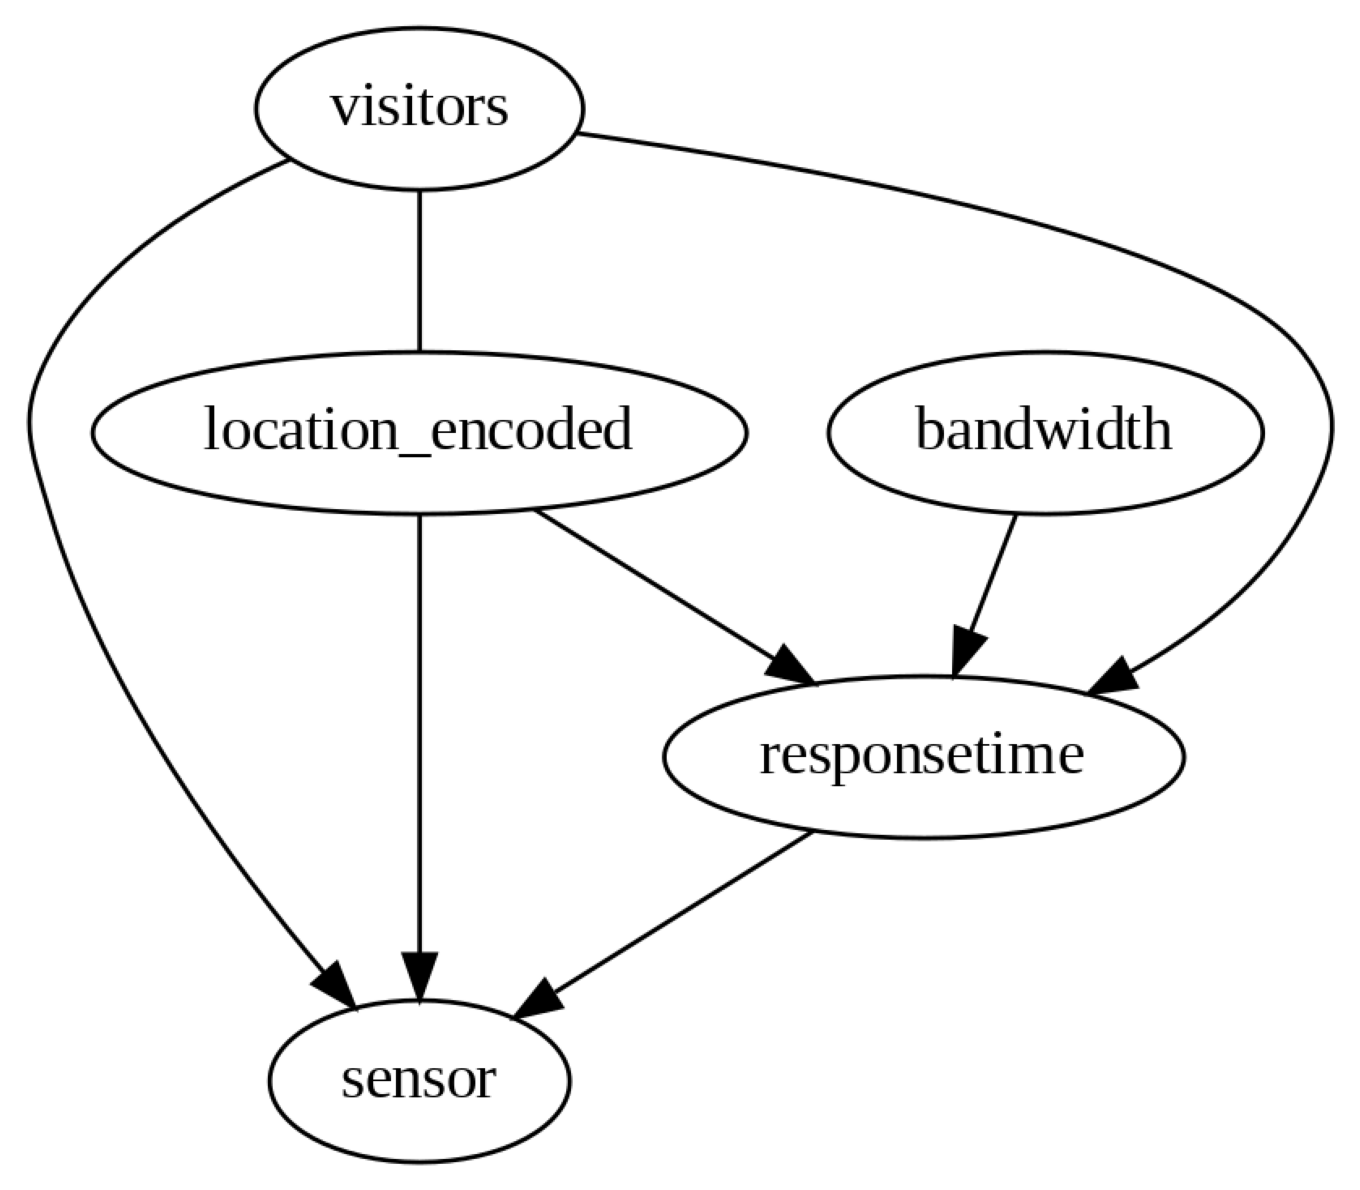

In [26]:
## Using Background Knowledge
start_time = time.time()

cg_without_background_knowledge = pc(data, 0.05, kci, True, 0,
                                      0)  # Run PC and obtain the estimated graph (CausalGraph object)
nodes = cg_without_background_knowledge.G.get_nodes()

# assert cg_without_background_knowledge.G.is_directed_from_to(nodes[2], nodes[8])
# assert cg_without_background_knowledge.G.is_undirected_from_to(nodes[7], nodes[17])

## Set forbidden Node Connection
bk = BackgroundKnowledge() \
    .add_forbidden_by_node(nodes[2], nodes[0]).add_forbidden_by_node(nodes[0], nodes[2]). \
    add_forbidden_by_node(nodes[4], nodes[0]).add_forbidden_by_node(nodes[0], nodes[4])


citest_cache_file_bk = "./cache/citest_cache_kci_bk.json"    # .json file

cg_with_background_knowledge = pc(data, 0.05, kci, True, 0, 0, background_knowledge=bk, cache_path=citest_cache_file_bk)

# visualization using pydot
cg_with_background_knowledge.draw_pydot_graph(labels=header)

# save the graph
pyd = GraphUtils.to_pydot(cg_with_background_knowledge.G, labels=header)
pyd.write_png('PC_graph_test_bk.png')

end_time = time.time()
time_taken = round((end_time - start_time), 3)
print(f"Time taken for PC algorithm: {time_taken} seconds")


In [ ]:
# Extract the learned causal graph
learned_graph = cg.G

# Print or use the learned graph
# print(learned_graph)

# Define the path where the learned graph will be saved
txt_file_path = 'PC_learned_graph.txt'

# Save the learned graph to a text file in truth format
with open(txt_file_path, 'w') as file:
    file.write(str(learned_graph))

# print(f'Learned graph saved to {txt_file_path}.')

# Read the content of the text file
with open(txt_file_path, 'r') as file:
    graph_output = file.read()

# Iterate through the header list and replace placeholders with variable names
for i, head in enumerate(header):
    graph_output = graph_output.replace(f'X{i+1}', head)

# Save the modified content back to the same file
with open(txt_file_path, 'w') as file:
    file.write(graph_output)

print(f'Modified graph content saved back to {txt_file_path}.')


Modified graph content saved back to PC_learned_graph.txt.


### Testing Conditional independence Test methods

In [ ]:
## Testing Conditional independence Test methods
from causallearn.utils.cit import CIT
mv_fisherz_obj = CIT(data, "fisherz") # construct a CIT instance with data and method name
# “fisherz”, “chisq”, “gsq”, “kci”, “mv_fisherz”
# pValue = mv_fisherz_obj(X, Y, S) # X, Y and condition_set : column indices of data
pValue = mv_fisherz_obj(0, 1, [2])
print(pValue)


0.8917819082344036


In [ ]:
## Testing Score Functions
# Local Score BIC
from causallearn.score.LocalScoreFunction import local_score_BIC
i = 3
PAi = [4]
parameters = {"lambda_value": 15}

score = local_score_BIC(data, i, PAi, parameters=parameters)

print(score)

[[38.13255501]]


In [ ]:
# Local Score BDEu
from causallearn.score.LocalScoreFunction import local_score_BDeu

i = 3
PAi = [4]

# Set the number of states for the random variables X_i and its parent variables
r_i_map = {i: 2, 4: 3}  # Replace 2 and 3 with the actual number of states for X_i and X_4

# Include the keys in the parameters dictionary with default values
parameters = {"sample_prior": True, "structure_prior": 1.0, "r_i_map": r_i_map}

score = local_score_BDeu(data, i, PAi, parameters)
print(score)


1138.221709230342


In [ ]:
# Local Score CV General
from causallearn.score.LocalScoreFunction import local_score_cv_general

# Replace Xi and PAi with the actual values
Xi = 3
PAi = [4]

# Set the parameters
parameters = {"kfold": 5, "lambda": 0.1}

# Call the local_score_cv_general function
score = local_score_cv_general(data, Xi, PAi, parameters)

# Print the result
print(score)


### Testing Metrics
##### Use only loading a ground-truth


In [ ]:
 # Load
from causallearn.graph.ArrowConfusion import ArrowConfusion
from causallearn.graph.AdjacencyConfusion import AdjacencyConfusion
from causallearn.graph.SHD import SHD

## Testing SHD against Truth Graph
print('Now start test_pc_load_linear_10_with_fisher_z ...')
truth_dag = load_truth_dag(truth_graph_path)
truth_dag = txt2generalgraph(truth_graph_path) # truth_dag is a GeneralGraph instance
truth_cpdag = dag2cpdag(truth_dag)
num_edges_in_truth = truth_dag.get_num_edges()

# Run PC with default parameters: stable=True, uc_rule=0 (uc_sepset), uc_priority=2 (prioritize existing colliders)
# cg = pc(data, 0.05, fisherz)  # Run PC and obtain the estimated graph (cg is CausalGraph object)
# benchmark_returned_graph = np.loadtxt("tests/TestData/benchmark_returned_results/linear_10_pc_fisherz_0.05_stable_0_2.txt")
# assert np.all(cg.G.graph == benchmark_returned_graph), INCONSISTENT_RESULT_GRAPH_ERRMSG

est = cg.G

# For arrows
arrow = ArrowConfusion(truth_cpdag, est)

arrowsTp = arrow.get_arrows_tp()
arrowsFp = arrow.get_arrows_fp()
arrowsFn = arrow.get_arrows_fn()
arrowsTn = arrow.get_arrows_tn()

arrowPrec = arrow.get_arrows_precision()
arrowRec = arrow.get_arrows_recall()

# For adjacency matrices
adj = AdjacencyConfusion(truth_cpdag, est)

adjTp = adj.get_adj_tp()
adjFp = adj.get_adj_fp()
adjFn = adj.get_adj_fn()
adjTn = adj.get_adj_tn()

adjPrec = adj.get_adj_precision()
adjRec = adj.get_adj_recall()

# Structural Hamming Distance
shd = SHD(truth_cpdag, est)

print(f"    pc(data, 0.05, fisherz)\tSHD: {shd.get_shd()} of {num_edges_in_truth}")
print(f"    pc(data, 0.05, fisherz)\tArrow Precision: {arrowPrec}")
print(f"    pc(data, 0.05, fisherz)\tArrow Recall: {arrowRec}")
print(f"    pc(data, 0.05, fisherz)\tAdjacency Precision: {adjPrec}")
print(f"    pc(data, 0.05, fisherz)\tAdjacency Recall: {adjRec}")
